## CIFAR10 Classification with Residual Neural Networks (ResNet)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.optim as optim
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import numpy as np

At the bottom, we have a Residual Network (ResNet) which solves the vanishing gradient problem of deep neural networks with skip connections. ResNet was proposed by Kaiming He et al, and the original paper can be found here: "Deep Residual Learning for Image Recognition" https://arxiv.org/abs/1512.03385

In [41]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = None
    ## This is usually the confusing part. If stride = 2, the feature map dimensions change so we must not only
    ## use Conv2d with stride = 2 to match the dimensions, we also need to increase the number of channels from in_channels to out_channels
    ## This increase in the number of channels can be implemented by using 1x1 convolution (kernel_size = 1).
    if stride==2: 
      self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

  def forward(self, x):
    res = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    ## If there is skip connection, we must match the dimensions
    if self.downsample is not None:
      res = self.downsample(x)
    out += res
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, resblock, n=3):
    super(ResNet, self).__init__()
    self.n = n
    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.avgpool = nn.AvgPool2d(8)
    self.fc1   = nn.Linear(64, 10)
    self.layer1 = self.create_layer(resblock, 16, 16, stride=1)
    self.layer2 = self.create_layer(resblock, 16, 32, stride=2)
    self.layer3 = self.create_layer(resblock, 32, 64, stride=2)

  def create_layer(self, resblock, in_channels, out_channels, stride):
    layers = nn.ModuleList()
    layers.append(resblock(in_channels, out_channels, stride))
    for i in range(self.n-1):
      layers.append(resblock(out_channels, out_channels, stride=1))
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    return out

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, BATCH_SIZE, scheduler=None, print_epoch=1):
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    
    print("==> Training starts!")
    print("="*50)
    for i in range(0, EPOCHS):
      model.train()
      if i % print_epoch == 0:
          print("Epoch %d:" %i)
      total_examples = 0
      correct_examples = 0
      total_train_loss = 0
      for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        out = model(inputs)
        loss = criterion(out, targets)
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(out, 1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
      train_avg_acc = correct_examples / total_examples
      train_acc.append(train_avg_acc)
      train_loss.append(total_train_loss / len(train_loader))
        
      model.eval()
      total_examples = 0
      correct_examples = 0
      total_val_loss = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            out = model(inputs)
            loss = criterion(out, targets)
            total_val_loss += loss.item()
            _, predicted = torch.max(out, 1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
          val_avg_acc = correct_examples / total_examples
          val_acc.append(val_avg_acc)
          val_loss.append(total_val_loss / len(val_loader))
      if scheduler:
        scheduler.step()
      if i % print_epoch == 0:
          print("Training accuracy: %.4f, Validation accuracy: %.4f" %(train_avg_acc, val_avg_acc))
      
    return train_acc, train_loss, val_acc, val_loss

def test_model(model, test_loader, criterion, optimizer):
  model.eval()
  total_examples = 0
  correct_examples = 0
  total_test_loss = 0
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        out = model(inputs)
        loss = criterion(out, targets)
        total_test_loss += loss.item()
        _, predicted = torch.max(out, 1)
        total_examples += targets.size(0)
        correct_examples += (predicted == targets).sum().item()
  test_avg_acc = correct_examples / total_examples
  print("Test accuracy: %.4f" % (test_avg_acc))
  test_avg_loss = total_test_loss / len(test_loader)
  print("Test loss: %.4f" % (test_avg_loss))
  return test_avg_acc, test_avg_loss

In [28]:
def plot_acc_loss(train_acc, train_loss, val_acc, val_loss, EPOCHS):
    x = np.arange(EPOCHS) + 1
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_acc, 'b-', label='Train Accuracy')
    plt.plot(x, val_acc, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(x, train_loss, 'b-', label='Train Loss')
    plt.plot(x, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Compose(
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
)
Files already downloaded and verified
Train Size: 45000
Val Size: 5000
Test Size: 10000


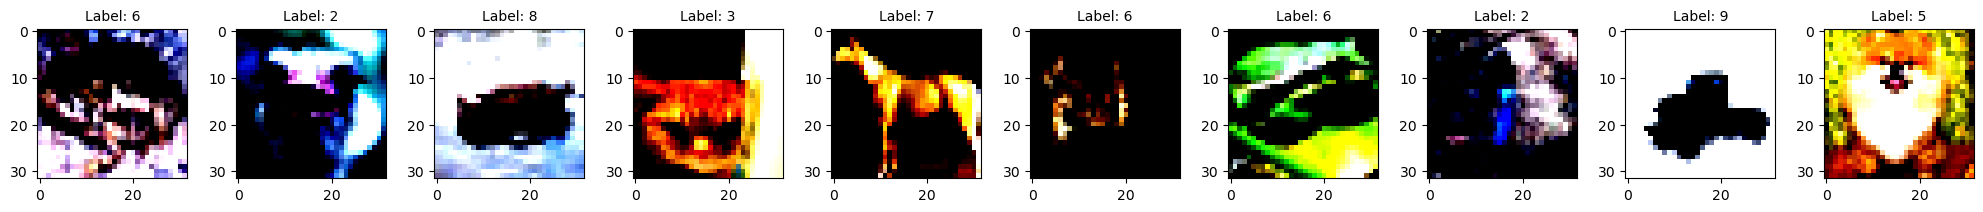

In [42]:
warnings.filterwarnings('ignore')

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(size=(32, 32), padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

CIFAR10_train_full = dsets.CIFAR10(root='CIFAR10_data/',
                                   train=True,
                                   transform=train_transform,
                                   download=True)

CIFAR10_train, CIFAR10_val = random_split(CIFAR10_train_full, [45000, 5000])

CIFAR10_val.dataset.transform = test_transform
print(CIFAR10_val.dataset.transform)

CIFAR10_test = dsets.CIFAR10(root='CIFAR10_data/',
                             train=False,
                             transform=test_transform,
                             download=True)

print('Train Size:', len(CIFAR10_train))
print('Val Size:', len(CIFAR10_val))
print('Test Size:', len(CIFAR10_test))

plt.figure(figsize=(20, 2))
for i in range(10):
    image, label = CIFAR10_train[i]
    plt.subplot(1, 10, i + 1)
    plt.imshow(image.permute(1, 2, 0).clamp(0, 1))
    plt.title(f'Label: {label}', fontsize=10)

plt.tight_layout()
plt.show()

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

model = ResNet(ResidualBlock).to(device)
data = torch.randn(1,3,32,32)
data = data.to(device)
out = model(data)
print(out.detach().cpu().numpy().shape)

Run on GPU...
(1, 10)


In [31]:
LR = 0.1
MOMENTUM = 0.9
REG = 1e-4
EPOCHS = 20
BATCH_SIZE = 100

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=REG)

train_loader = torch.utils.data.DataLoader(
    dataset=CIFAR10_train, batch_size=BATCH_SIZE, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    dataset=CIFAR10_val, batch_size=BATCH_SIZE, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    dataset=CIFAR10_test, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
train_acc, train_loss, val_acc, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, BATCH_SIZE, None, 5)

==> Training starts!
Epoch 0:
Training accuracy: 0.4185, Validation accuracy: 0.5190
Epoch 5:
Training accuracy: 0.8105, Validation accuracy: 0.7678
Epoch 10:
Training accuracy: 0.8704, Validation accuracy: 0.7670
Epoch 15:
Training accuracy: 0.9013, Validation accuracy: 0.7874


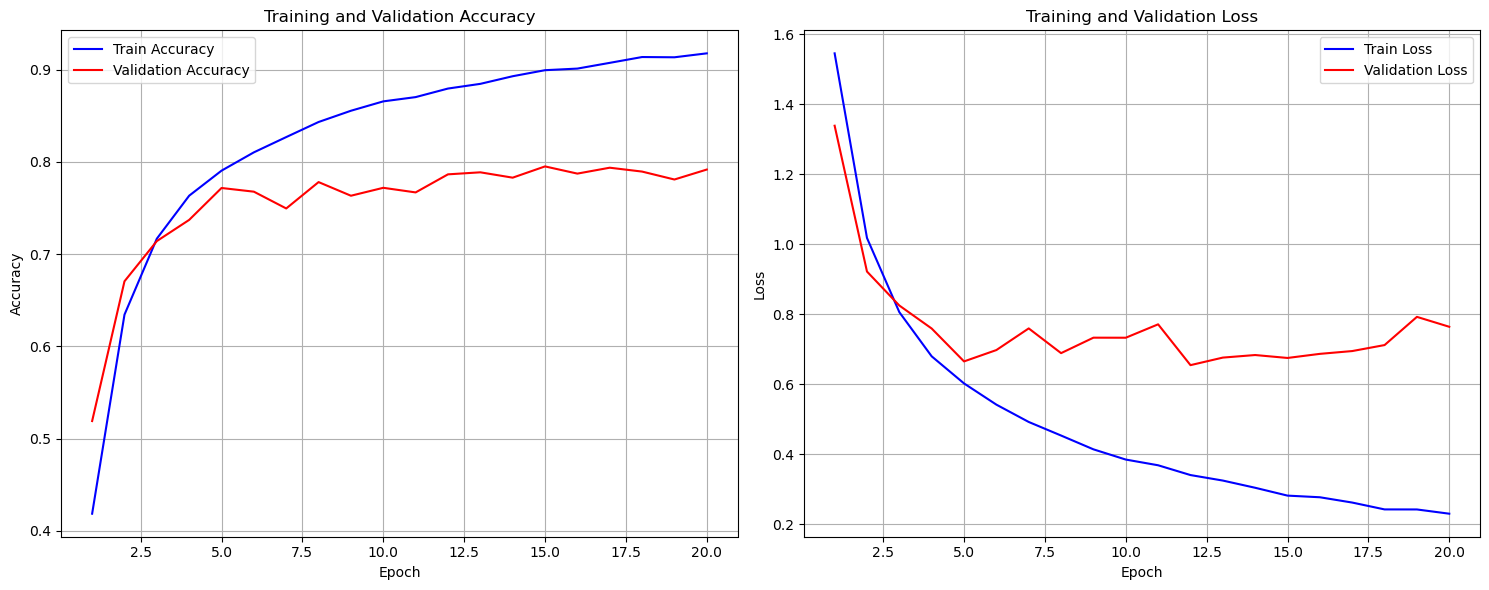

In [33]:
plot_acc_loss(train_acc, train_loss, val_acc, val_loss, EPOCHS)

In [34]:
test_model(model, test_loader, criterion, optimizer)

Test accuracy: 0.7808
Test loss: 0.7772


(0.7808, 0.7771923080086708)

When we implemented the 'CIFAR_CNN' model in the CNN notebook, our model acheived ~80% accuracy with 1.1M parameters: 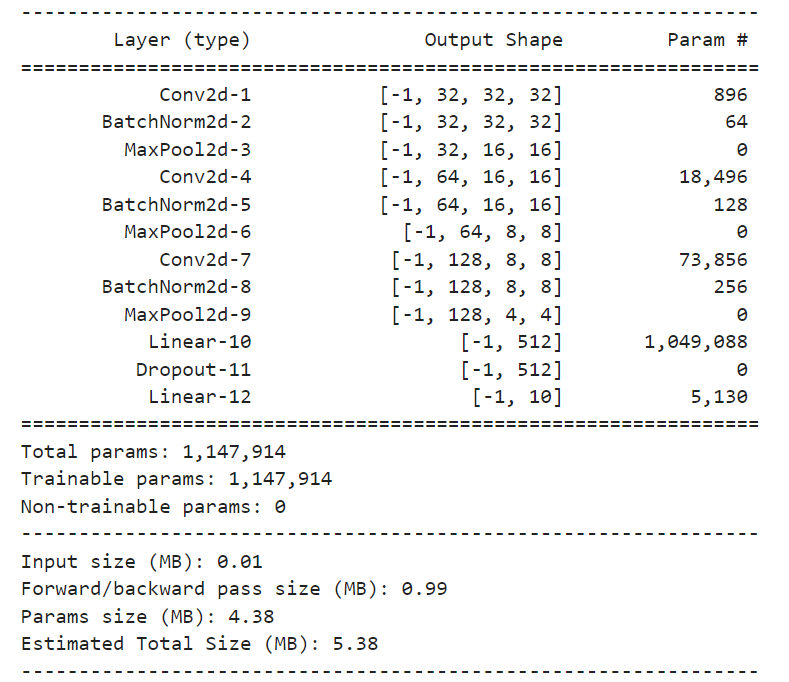

At the bottom, we have our ResNet20 model structure. We see that it has 0.27M parameters, which is about 25% of that of the CIFAR_CNN model. Yet, we see that the accuracy of the ResNet20 is comparable to that of the bigger CNN model. This effectively shows the power of the ResNet architecture, with the use of skip connections to ensure that the higher layer performs at least as good as the lower layer.

In [50]:
from torchsummary import summary

model = ResNet(ResidualBlock).to('cuda')
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,320
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,320
       BatchNorm2d-6           [-1, 16, 32, 32]              32
     ResidualBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,320
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,320
      BatchNorm2d-11           [-1, 16, 32, 32]              32
    ResidualBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,320
      BatchNorm2d-14           [-1, 16,

We will use a technique called learning rate decay, which is a method to reduce our learning rate of our optimizer during training. If we use a high learning rate, there is a chance that we overshoot and miss the optimal solution. If we use a small learning rate, the learning process may take too long or be stuck at a local minimum. Learning rate decay starts off with a high learning rate to make big progress towards the optimal solution. Later, we decay the learning rate to avoid overshooting. For a strictly decreasing learning rate, we can define a decaying learning rate scheduler within the LambdaLR() method. There are other options, for instance, CosineAnnealingLR, which allows the learning rate to periodically decrease and increase like a cosine function.

In [51]:
model = ResNet(ResidualBlock).to(device)

LR = 0.1
MOMENTUM = 0.9
REG = 1e-4
EPOCHS = 25
BATCH_SIZE = 100

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=REG)

# Multiply LR by 0.1 after 15 epochs
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda epoch: 0.1 if epoch >= 15 else 1.0, 
    last_epoch=-1,
    verbose=True
)

# # Decay LR by 10% every epoch
# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer=optimizer,
#     lr_lambda=lambda epoch: 0.95 ** epoch,
#     last_epoch=-1,
#     verbose=True
# )

# # Cosine Annealing; T_max = period, eta_min = minimum LR
# scheduler = optim.lr_scheduler.CosineAnnealingLR(
#     optimizer=optimizer,
#     T_max=15,
#     eta_min=0
# )

train_acc, train_loss, val_acc, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, BATCH_SIZE, scheduler, 5)

==> Training starts!
Epoch 0:
Training accuracy: 0.3794, Validation accuracy: 0.4700
Epoch 5:
Training accuracy: 0.8043, Validation accuracy: 0.7430
Epoch 10:
Training accuracy: 0.8701, Validation accuracy: 0.7794
Epoch 15:
Training accuracy: 0.9539, Validation accuracy: 0.8450
Epoch 20:
Training accuracy: 0.9946, Validation accuracy: 0.8400


As shown below, we see a jump in both training and validation accuracy at the time of learning rate decay. The jump in accuracy is a positive sign that the model is benefiting from the reduced learning rate. It represents the model’s ability to settle into a better or more optimal solution in the loss landscape by taking smaller steps in the parameter space. This allows it to navigate the loss landscape more carefully, avoiding overshooting minima.
One might wonder why the validation accuracy stays relatively the same after the learning rate decay whereas the validation loss increases.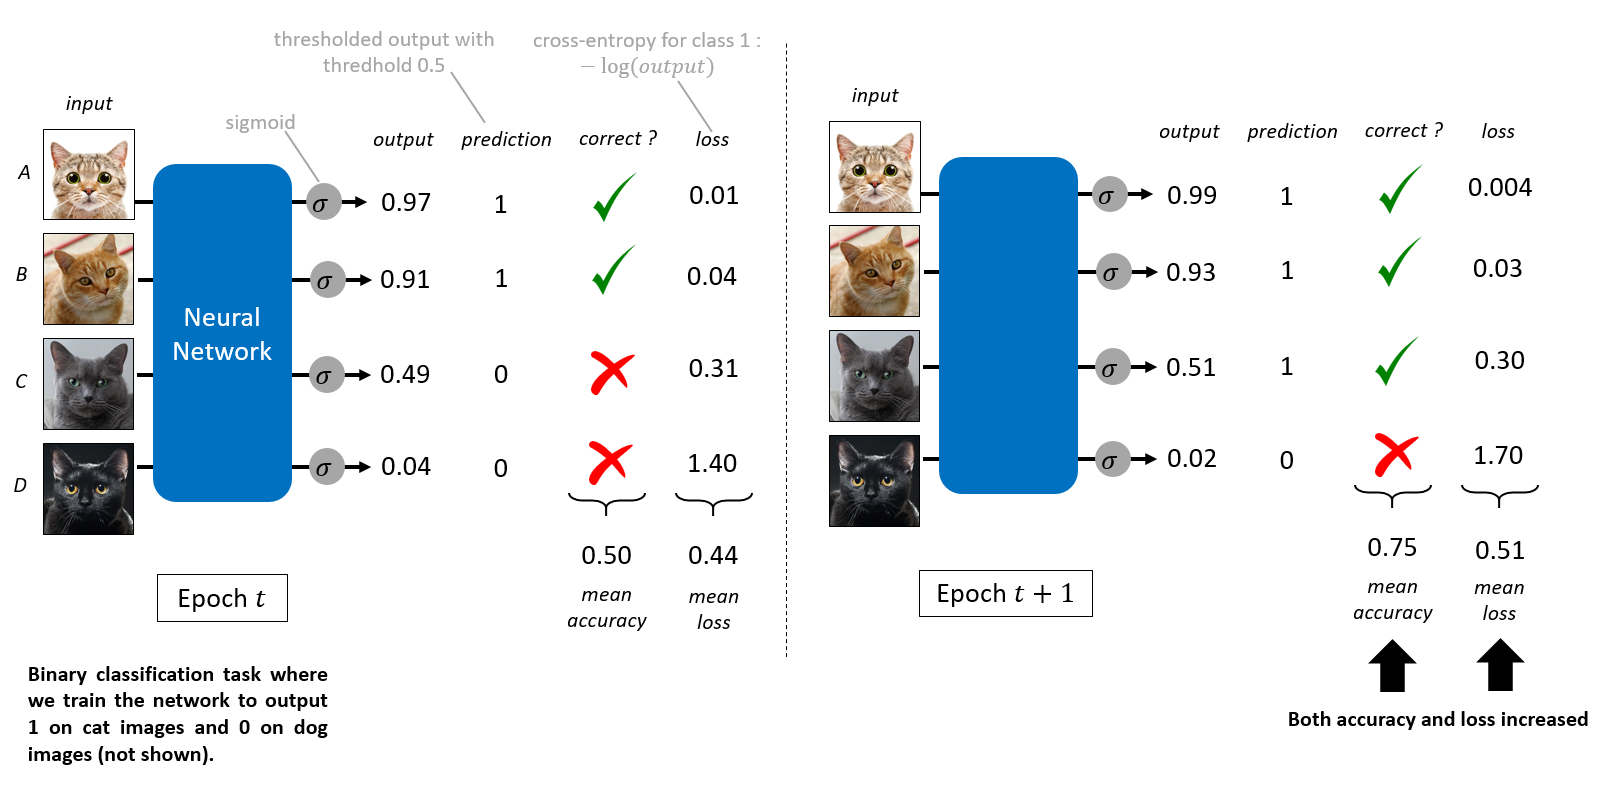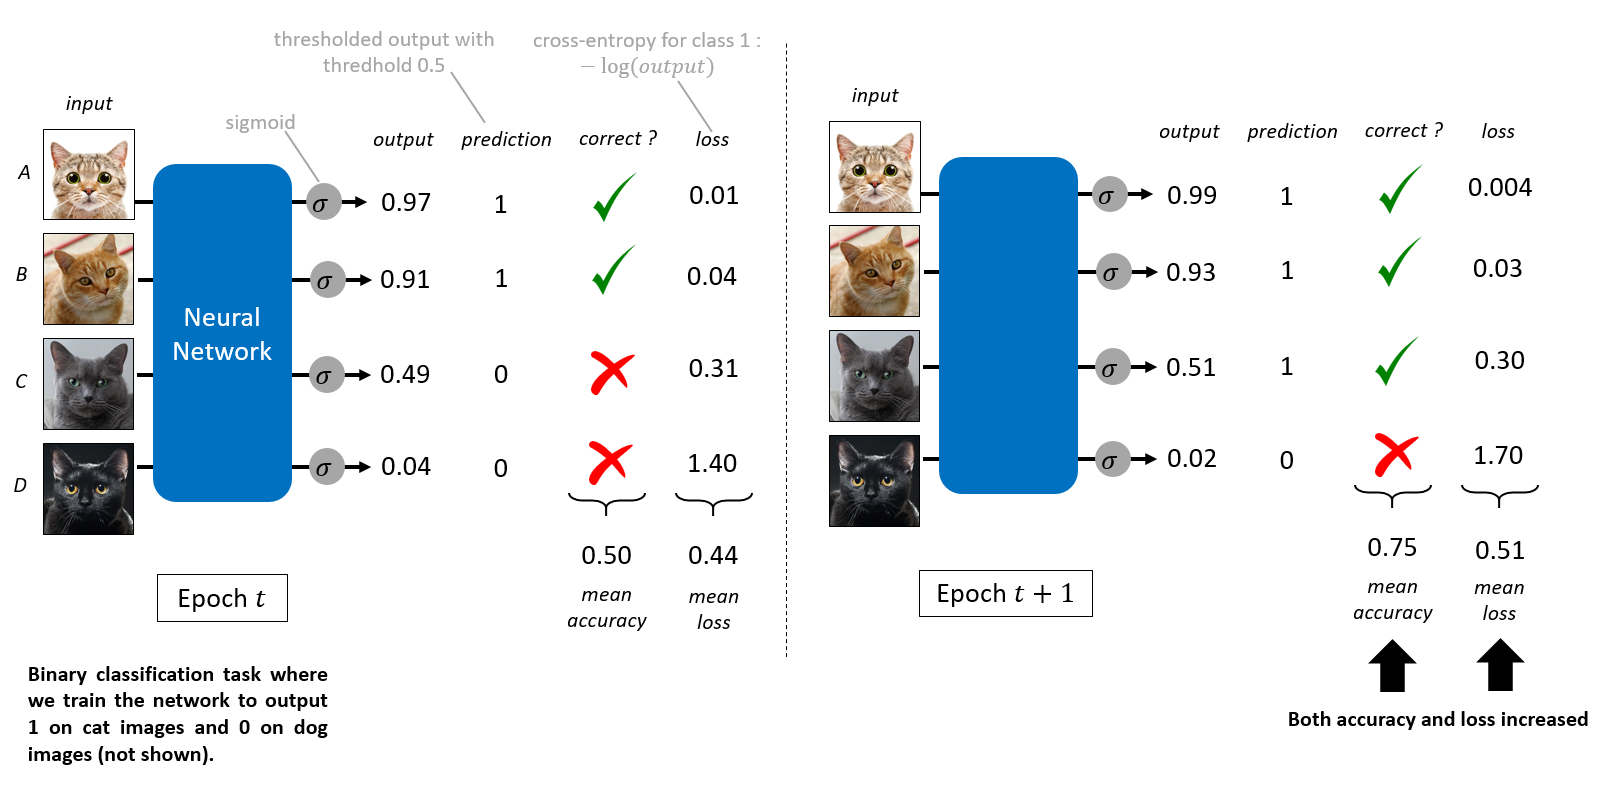

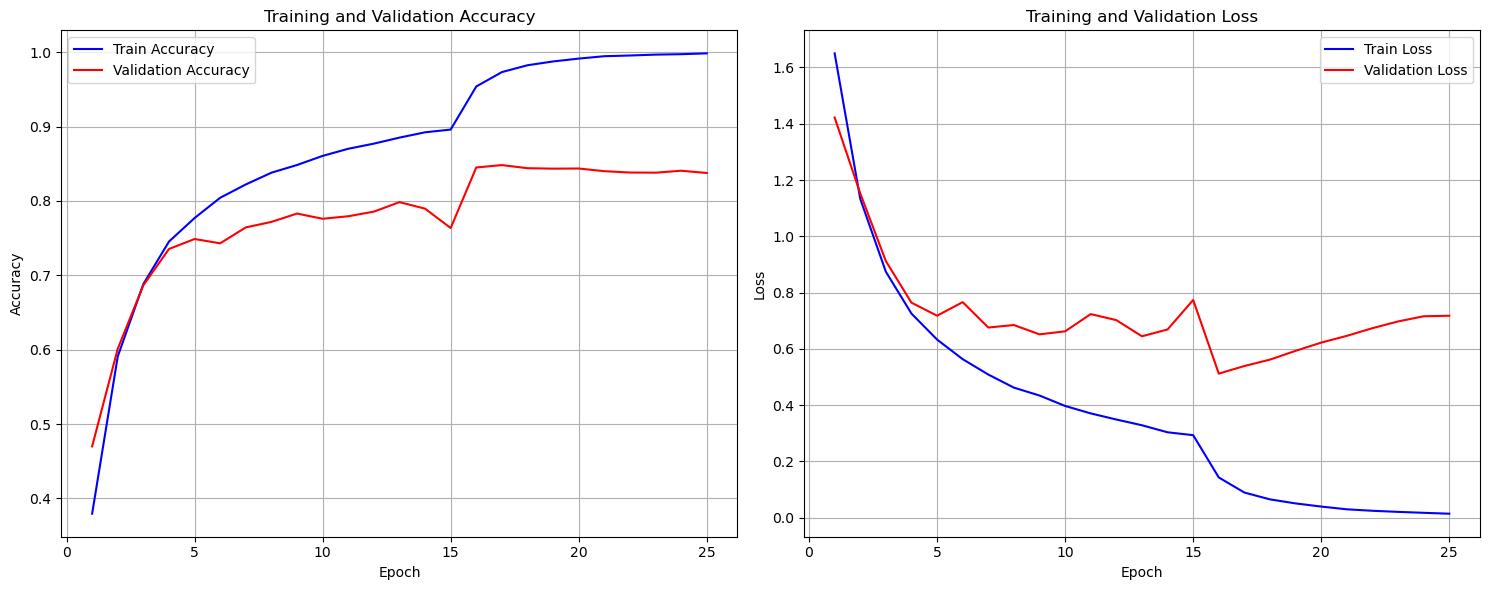

In [52]:
plot_acc_loss(train_acc, train_loss, val_acc, val_loss, EPOCHS)

In [53]:
test_model(model, test_loader, criterion, optimizer)

Test accuracy: 0.8321
Test loss: 0.7317


(0.8321, 0.7317020332813263)

With the use of learning rate decay, we have increased our model's performance on the CIFAR10 dataset by 5.3%.